# Project 1: Visualizing Underwater Fish Imagery 

#### University of Delaware

#### MATH637

#### 05/21/2021

#### Brett Isken

## 1. Introduction

The following two datasets were used to examine underwater images featuring fish.

https://swfscdata.nmfs.noaa.gov/labeled-fishes-in-the-wild/

https://github.com/AIMS/ozfish

The goal was to look at the feature space of underwater images and use different feature extraction techniques visualize the data. 
PCA was used to plot the data in a low dimensional space and an SVM used to classify the fish images.


In [2]:
# used for manipulating directory paths
import os
import csv

# Scientific and vector computation for python
import numpy as np
from numpy import linalg as la

# Plotting library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import cv2

from skimage.feature import hog
from sklearn import svm,manifold
from sklearn.decomposition import KernelPCA
from sklearn import manifold, datasets, cluster, preprocessing
from sklearn.metrics import classification_report,accuracy_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
def load_video(file):
    cap = cv2.VideoCapture(file)
    if (cap.isOpened()== False):
        print("Error opening video stream or file")
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    return frames

In [5]:
def load_lfw_pos(folder,rez):
    bounding_file = 'Positive_fish_(ALL)-MARKS_DATA.dat'
    f = open(os.path.join(folder,bounding_file))
    lines = np.array(f.read().splitlines())
    f.close()
    images = []
    file_names = []
    for line in lines:
        bounding = line.split(" ")
        img = cv2.imread(os.path.join(folder,bounding[0]))
        for i in range(int(bounding[1])):
            x0 = int(bounding[4*i+2])
            x1 = x0+int(bounding[4*i+4])
            y0 = int(bounding[4*i+3])
            y1 = y0+int(bounding[4*i+5])
            fish = cv2.resize(img[y0:y1,x0:x1],rez)
            file_names.append([folder,bounding[0]])
            images.append(fish)
    return (np.array(images),np.array(file_names))

In [6]:
def load_oz_neg(folder,bounding_file,rez):
    f = open(bounding_file)
    lines = np.array(f.read().splitlines())
    f.close()
    images = []
    file_names = []
    for line in lines[1:]:
        bounding = line.split(",")
        img = cv2.imread(os.path.join(folder,bounding[0]))
        x0 = int(bounding[1])
        x1 = x0+int(bounding[3])
        y0 = int(bounding[2])
        y1 = y0+int(bounding[4])
        fish = cv2.resize(img[y0:y1,x0:x1],rez)
        file_names.append([folder,bounding[0]])
        images.append(fish)
    return (np.array(images),np.array(file_names))

In [7]:
def load_image(filename,folder,rez=None): 
    img = cv2.imread(os.path.join(folder,filename))
    if rez:
        try:
            img = cv2.resize(img,rez)
        except Exception as e:
            img = None
    return img

In [8]:
def write_image(filename,img):
    cv2.imwrite(filename,img)

In [9]:
def hog_extract(X,orientations,ppc,cpb,norm):
    hog_features = []
    for row in X:
        fd = hog(row, orientations=orientations, pixels_per_cell=ppc,cells_per_block=cpb,block_norm=norm)
        hog_features.append(fd)
    return np.array(hog_features)

In [10]:
def convert_color(X,color):
    cvt_images = []
    idx = 0
    for image in X:
        try:
            cvt_image = cv2.cvtColor(image, color)
            cvt_images.append(cvt_image)
        except Exception as e:
            print('Failed idx: {0}\nError: {1}'.format(idx,e))
        idx+=1
    return np.array(cvt_images)

In [11]:
def sample_data(x,count):
    idx = np.random.choice(x.shape[0],count,replace=False)
    x_sample = x[idx]
    return x_sample 

def sample_data_label(x,label,count):
    idx = np.random.choice(x.shape[0],count,replace=False)
    x_sample = x[idx]
    label_sample = label[idx]
    return (x_sample,label_sample)

In [12]:
#load file paths for a given folder
#returns np array : n x [folder,filename]
def read_paths(folder):
    paths = []
    for filename in os.listdir(folder):
        paths.append([folder,filename])
    return np.array(paths)

In [13]:
def load_images_from_paths(paths,rez):
    images = []
    for path in paths:
        try:
            img = cv2.imread(os.path.join(path[0],path[1]))
            img = cv2.resize(img,rez)
            images.append(img)
        except Exception as e:
            print('Failed to load: {0} {1}\n{2}'.format(path[0],path[1],e))
    return np.array(images)

# -----------------------------------------------------------------------------------------------------------

In [14]:
lfw_pos_folder = 'C:/Users/Brett/Documents/data/Labeled-Fish-in-the-Wild/Training_and_validation/Positive_fish/'
lfw_neg_folder = 'C:/Users/Brett/Documents/data/Labeled-Fish-in-the-Wild/Negatives (seabed)/'
oz_pos_folder = 'C:/Users/Brett/Documents/data/OzFish/crops'
oz_neg_folder = 'D:/New folder/archive/FDFML/frames'
oz_neg_bounding = 'C:/Users/Brett/Documents/data/frames_label_negative.txt'


oz_pos_paths_all = read_paths(oz_pos_folder)
oz_neg_paths_all = read_paths(oz_neg_folder)
lfw_neg_paths = read_paths(lfw_neg_folder)
print('Oz Positive Paths: ',oz_pos_paths_all.shape)
print('Oz Negative Paths: ',oz_neg_paths_all.shape)
print('Lfw Negative Paths: ',lfw_neg_paths.shape)

Oz Positive Paths:  (80823, 2)
Oz Negative Paths:  (64385, 2)
Lfw Negative Paths:  (149, 2)


In [15]:
rez = (64,128)
n = 250

lfw_pos_images_all,lfw_pos_paths_all = load_lfw_pos(lfw_pos_folder,rez)
bad_fish_idx = np.where((np.char.find(lfw_pos_paths_all[:,1],'_C')>=0) == False)
print(len(bad_fish_idx))

lfw_pos_images,lfw_pos_paths = sample_data_label(
    lfw_pos_images_all[bad_fish_idx],lfw_pos_paths_all[bad_fish_idx],n)
lfw_neg_images = load_images_from_paths(lfw_neg_paths,rez)


oz_pos_paths = sample_data(oz_pos_paths_all,n)

oz_pos_images = load_images_from_paths(oz_pos_paths,rez)
oz_neg_images,oz_neg_paths = load_oz_neg(oz_neg_folder,oz_neg_bounding,rez)

1
Failed to load: C:/Users/Brett/Documents/data/Labeled-Fish-in-the-Wild/Negatives (seabed)/ background_sb.txt
OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Failed to load: C:/Users/Brett/Documents/data/Labeled-Fish-in-the-Wild/Negatives (seabed)/ _readme-negatives.txt
OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [16]:
string = 'Oz Positive Images: {0}\nOz Negative Images: {1}\nLfw Positive Images: {2}\nLfw Negative Images: {3}\n'.format(oz_pos_images.shape,oz_neg_images.shape,lfw_pos_images.shape,lfw_neg_images.shape)
print(string)

Oz Positive Images: (250, 128, 64, 3)
Oz Negative Images: (299, 128, 64, 3)
Lfw Positive Images: (250, 128, 64, 3)
Lfw Negative Images: (147, 128, 64, 3)



In [17]:
oz_images = np.vstack((oz_pos_images,oz_neg_images))
oz_paths = np.vstack((oz_pos_paths,oz_neg_paths))
oz_labels = np.vstack((np.ones((oz_pos_images.shape[0],1)),np.zeros((oz_neg_images.shape[0],1))))

lfw_images = np.vstack((lfw_pos_images,lfw_neg_images))
lwf_paths = np.vstack((lfw_pos_paths,lfw_neg_paths))
lfw_labels = np.vstack((np.ones((lfw_pos_images.shape[0],1)),np.zeros((lfw_neg_images.shape[0],1))))

images = np.vstack((oz_images,lfw_images))
paths = np.vstack((oz_paths,lwf_paths))
labels = np.vstack((oz_labels,lfw_labels))

print('oz',oz_images.shape)
print('lfw',lfw_images.shape)
print('all',images.shape)
print('all labels',labels.shape)

oz (549, 128, 64, 3)
lfw (397, 128, 64, 3)
all (946, 128, 64, 3)
all labels (946, 1)


# -----------------------------------------------------------------------------------------------------------

In [ ]:
#display all images in 9 pictures
for i in np.arange(8):
    filename = 'ozfish_{0}-{1}_128x128.jpg'.format(1000*i+1,1000*i+1000)
    temp = ozfish_images[1000*i:1000*i+1000]
    write_image(filename,np.vstack((np.hstack(temp[0:100]),
                                      np.hstack(temp[100:200]),
                                      np.hstack(temp[200:300]),
                                      np.hstack(temp[400:500]),
                                      np.hstack(temp[500:600]),
                                      np.hstack(temp[600:700]),
                                      np.hstack(temp[700:800]),
                                      np.hstack(temp[800:900]),
                                      np.hstack(temp[900:1000]),
                                     )))
filename = 'ozfish_{0}-{1}_128x128.jpg'.format(80001,80823)
temp = np.vstack((ozfish_images[80000:80823],np.zeros((177,128,128,3))))
write_image(filename,np.vstack((np.hstack(temp[0:100]),
                                      np.hstack(temp[100:200]),
                                      np.hstack(temp[200:300]),
                                      np.hstack(temp[400:500]),
                                      np.hstack(temp[500:600]),
                                      np.hstack(temp[600:700]),
                                      np.hstack(temp[700:800]),
                                      np.hstack(temp[800:900]),
                                      np.hstack(temp[900:1000]),
                                     )))

# -----------------------------------------------------------------------------------------------------------

In [294]:
gray_images = convert_color(images, cv2.COLOR_BGR2GRAY)
#write_image('test.png',gray_images[0])
images_hog = hog_extract(images,9,(8,8),(4,4),'L2')
gray_images_hog = hog_extract(gray_images,9,(8,8),(4,4),'L2')

In [16]:
clusters = 800

sift = cv2.xfeatures2d.SIFT_create()
sift_descriptors = []
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    if (des is None):
        des = [np.zeros((128,), np.float32)]
    for x in des:
        sift_descriptors.append(x)
kmeans = cluster.KMeans(n_clusters=clusters).fit(sift_descriptors)

In [84]:
histograms = []

for image in images:
    kp, des = sift.detectAndCompute(image, None)
    histogram = np.zeros(clusters)
    
    if (des is None):
        des = np.zeros((1,128), np.float32)
    nkp = np.size(kp)
    for x in des:
        idx = kmeans.predict([x])
        histogram[idx] += 1
    histograms.append(histogram)

<class 'numpy.float32'>


# -----------------------------------------------------------------------------------------------------------

In [20]:
X_all = hog_extract(convert_color(X_images, cv2.COLOR_BGR2GRAY),9,(8,8),(4,4),'L2')
X_lfw_images = hog_extract(convert_color(X_lfw_images, cv2.COLOR_BGR2GRAY),9,(8,8),(4,4),'L2')
X_oz_images = hog_extract(convert_color(X_oz_images, cv2.COLOR_BGR2GRAY),9,(8,8),(4,4),'L2')

#oz_labels
#lfw_labels
#labels

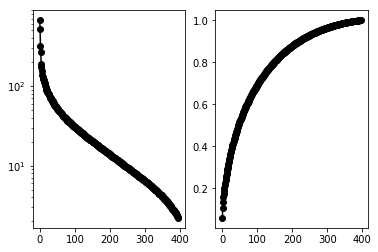

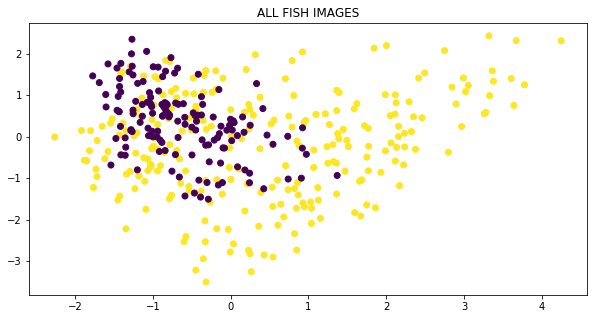

In [26]:
#SVD
Xc = X_lfw_images - np.mean(X_lfw_images, axis=0)
U,S,VT = la.svd(Xc,full_matrices=False)
S=S**2
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.semilogy(S[:-2],'-o',color='k')
ax2 = fig.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.show()

PC_k = VT[0:3,:].T
#project
X_pca = Xc.dot(PC_k)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('ALL FISH IMAGES')
ax.scatter(X_pca[:,0], X_pca[:,1],c=lfw_labels.flatten())

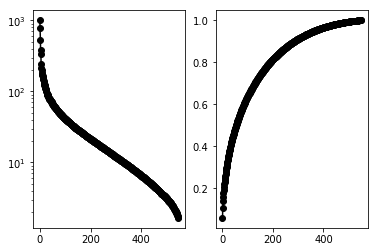

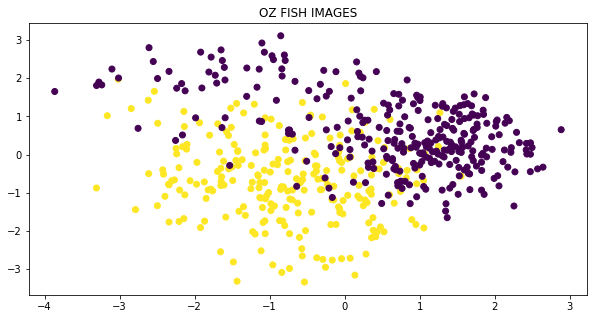

In [27]:
#SVD
Xc = X_oz_images - np.mean(X_oz_images, axis=0)
U,S,VT = la.svd(Xc,full_matrices=False)
S=S**2
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.semilogy(S[:-2],'-o',color='k')
ax2 = fig.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.show()

PC_k = VT[0:3,:].T
#project
X_pca = Xc.dot(PC_k)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('OZ FISH IMAGES')
ax.scatter(X_pca[:,0], X_pca[:,1],c=oz_labels.flatten())

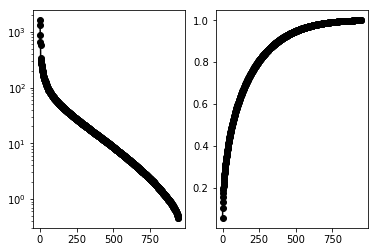

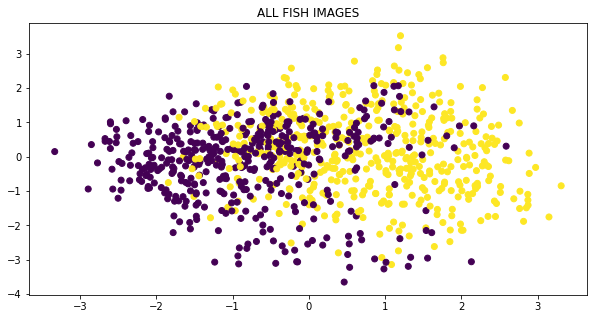

In [28]:
#SVD
Xc = X_all - np.mean(X_all, axis=0)
U,S,VT = la.svd(Xc,full_matrices=False)
S=S**2
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.semilogy(S[:-2],'-o',color='k')
ax2 = fig.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.show()

PC_k = VT[0:3,:].T
#project
X_pca = Xc.dot(PC_k)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('ALL FISH IMAGES')
ax.scatter(X_pca[:,0], X_pca[:,1],c=labels.flatten())

In [313]:
kpca = KernelPCA(n_components=100, kernel='rbf',gamma=.001)
X_transformed = kpca.fit_transform(X)

In [264]:
isomap = manifold.Isomap(n_components=8)
X_transformed = isomap.fit_transform(X)

In [268]:
tsne = manifold.TSNE(n_components=3,perplexity=7)
X_transformed = tsne.fit_transform(X)

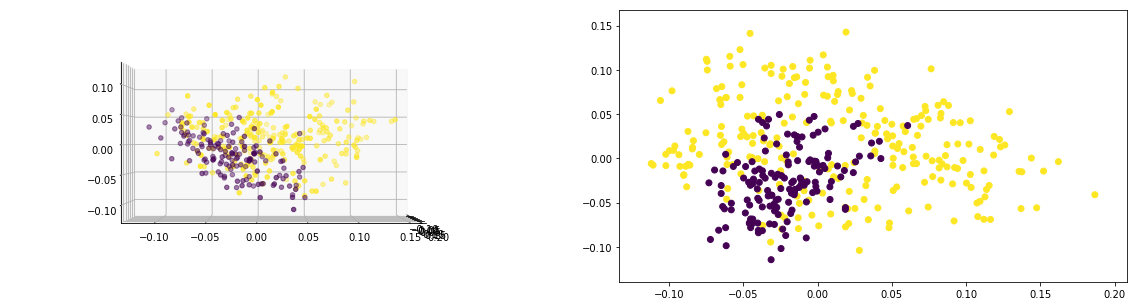

In [314]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2)
ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2],c=LABELS.flatten())
ax2.scatter(X_transformed[:,0], X_transformed[:,1],c=LABELS.flatten())
ax.view_init(0,0)

plt.show()

In [ ]:
#file_names[np.where((X_transformed[:,0] > .135))]
pass

# -----------------------------------------------------------------------------------------------------------

In [311]:
clf = svm.SVC(kernel='rbf')
data_frame = np.hstack((X,LABELS))
np.random.shuffle(data_frame)

percentage = 80
partition = int(len(X)*percentage/100)
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)

SVC()

In [312]:
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9


              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        29
         1.0       0.91      0.94      0.92        51

    accuracy                           0.90        80
   macro avg       0.90      0.88      0.89        80
weighted avg       0.90      0.90      0.90        80



In [11]:
folder = 'C:/Users/Brett/Documents/data/Labeled-Fish-in-the-Wild/test/'
file = 'Test_ROV_video_h264_full.mp4'
wow = load_video(os.path.join(folder,file)

Can't receive frame (stream end?). Exiting ...


In [22]:
fish = cv2.resize(frames[2103][400:600,700:1100,:],(128,64))
write_image(fish)
fd,hog_image = hog(fish, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
y_pred = clf.predict(fd.reshape(1,len(fd)))

# -----------------------------------------------------------------------------------------------------------